# MACHINE LEARNING PROJECT: PREDICTING COMMERCIAL REAL ESTATE PRICES

In this project, we will study the performance of several popular machine learning models in predicting commercial real estate prices.

In [2]:
import os
from warnings import filterwarnings
from tempfile import mkdtemp
from shutil import rmtree
from time import sleep

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from cycler import cycler

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     GridSearchCV,
                                     KFold)

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.linear_model import (LinearRegression,
                                  Lasso,
                                  Ridge)

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import (OneHotEncoder,
                                   PolynomialFeatures,
                                   PowerTransformer,
                                   StandardScaler,
                                   LabelEncoder)
from sklearn.svm import SVR

from sklearn.metrics import r2_score

from catboost import CatBoostRegressor

pd.options.display.float_format = '{:.2f}'.format
filterwarnings('ignore')


In [3]:
# Plots styling
figure = {'figsize': (16, 6),
          'facecolor': '#f9f9f9',
          'subplot.wspace': 0.1,
          'dpi': 120}

colors = ["#ab5787",
          "#51b2e5",
          "#703c5c",
          "#168dd9",
          "#d190b6",
          "#00609f",
          "#d365ba",
          "#154866",
          "#666666",
          "#c4c4c4"]

axes = {'grid': True,
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False,
        'grid.axis': 'y',
        'facecolor': '#f9f9f9',
        'edgecolor': '#f9f9f9',

        'xmargin': 0,
        'prop_cycle': cycler('color', colors)}

grid = {'color': '#979797', 'linewidth': 0.2}

tick = {'color': '#979797', 'major.size': 0, 'minor.size': 0}

plt.rc('figure', **figure)
plt.rc('axes', **axes)
plt.rc('grid', **grid)
plt.rc(('xtick', 'ytick'), **tick)


First, we will write a small web scraper to fetch the data from a real estate agency. 

In [4]:
def scrap_pages(number_of_pages, sleep_time=1):

    link = 'https://retail.realtor.ru/moscow/'

    dict_descr = {'Наименование': [],
                  'Описание': [],
                  'Цена': [],
                  'Площадь': []}

    dict_prop = {'Тип сделки': [],
                 'Метро': [],
                 'Этаж': [],
                 'Год постройки': [],
                 'Район (Округ)': [],
                 'Тип объекта': [],
                 'Расстояние пешком до метро': [],
                 'Месячный арендный поток': []}

    params = {'tenant': "0",
              'type_payback_yield': "1",
              'payback': "0",
              'yield': "0",
              'area_from_1': "",
              'area_to_1': "",
              'type_price': "1",
              'price_from_1': "",
              'price_to_1': "",
              'price_m_from_1': "",
              'price_m_to_1': "",
              'type_district_metro': "1",
              'district_214[]': ['ВАО',
                                 'ЗАО',
                                 'САО',
                                 'СВАО',
                                 'СЗАО',
                                 'ЦАО',
                                 'ЮАО',
                                 'ЮВАО',
                                 'ЮЗАО'],
              'hot': "0",
              'is_new': "",
              'metro_to': "0",
              'e_power_from': "",
              'e_power_to': "",
              'fadd': "1",
              'deal': "1",
              'city': "214",
              'order': 'date_desc',
              'filter': 'Y',
              'PAGEN_1': "1"}

    for i in tqdm(range(1, number_of_pages+1)):
        params['PAGEN_1'] = str(i)
        url = requests.get(link, params=params)
        bsobj = BeautifulSoup(url.content, 'lxml')
        links = ["".join(['https://retail.realtor.ru',
                 ob['href']]) for ob in bsobj
                 .find_all('a', class_='img br5')]

        for link_full in links:

            sleep(sleep_time)
            url_full = requests.get(link_full)
            bsobj_full = BeautifulSoup(url_full.content, 'lxml')
            dict_descr['Наименование'].append(bsobj_full.h1.text.strip())
            dict_descr['Описание'].append(bsobj_full
                                                  .find('span',
                                                        {'itemprop':
                                                         'description'})
                                                  .text.strip())
            dict_descr['Цена'].append(bsobj_full
                                          .find('div', class_='price_m2')
                                          .span.text.strip())
            dict_descr['Площадь'].append(bsobj_full
                                                .find('div', class_='area')
                                                .text.strip())

            temp_dict = {ob.find('', class_='k').text.strip():
                         ob.find('', class_='v').text.strip()
                         for ob in bsobj_full.find_all('div', class_='prop')}

            for key in dict_prop:
                if key in temp_dict.keys():
                    dict_prop[key].append(temp_dict[key])
                else:
                    dict_prop[key].append(np.nan)

    return pd.DataFrame({'name': dict_descr['Наименование'],
                         'description': dict_descr['Описание'],
                         'price': dict_descr['Цена'],
                         'area': dict_descr['Площадь'],
                         'type': dict_prop['Тип сделки'],
                         'subway': dict_prop['Метро'],
                         'floor': dict_prop['Этаж'],
                         'year': dict_prop['Год постройки'],
                         'region': dict_prop['Район (Округ)'],
                         'object': dict_prop['Тип объекта'],
                         'dist': dict_prop['Расстояние пешком до метро'],
                         'lease_amount': dict_prop['Месячный арендный поток']})


In [5]:
# We'll only need a subset of features
def extract_features(df):
    columns = ['name', 'price', 'area', 'region', 'lease_amount']

    df = df.copy()
    df = df[columns]
    df['price'] = df['price'].str.replace(' ', '').astype('float')
    df['area'] = df['area'].str.extract('([\d.]*) м2', expand=False)
    df['lease_amount'] = (df['lease_amount'].str.replace('[ руб.]*', '')
                          .fillna(0))
    df = df.set_index('name')

    return df


In [6]:
if not os.path.exists('data.csv'):
    df = scrap_pages(40, sleep_time=0.5)
    df.to_csv('data.csv')

df = (pd.read_csv('data.csv')
      .pipe(extract_features)
      .assign(price=lambda x: x['price'] / 1e+3,
              area=lambda x: x['area'].astype('float'),
              region=lambda x: x['region'].astype('str'),
              lease_amount=lambda x: x['lease_amount'].astype('float')))
df.head()


,price,area,region,lease_amount
name,,,,
"Продажа помещения 190.60 кв.м. ЮВАО ул. ул. октябрьский проспект, 1к1",283.32,190.60,ЮВАО,387490.00
"Продажа помещения 7700 кв.м. ЦАО ул. Кожевническая, 10",175.32,7700.00,ЦАО,0.00
"Продажа помещения 630 кв.м. ЗАО ул. Дорогомиловская Б., 9",317.46,630.00,ЗАО,0.00
"Продажа помещения 61 кв.м. ЦАО проезд Кожевнический, 4",330.00,61.00,ЦАО,0.00
"Продажа помещения 220 кв.м. ЦАО ул. Татарская, 14",318.18,220.00,ЦАО,0.00


In [7]:
df.describe(include='all')


,price,area,region,lease_amount
count,1200.00,1200.00,1200,1200.00
unique,nan,nan,10,nan
top,nan,nan,ЦАО,nan
freq,nan,nan,503,nan
mean,418.36,1990.78,NaN,1182631.73
std,428.07,6366.25,NaN,4287957.11
min,7.47,10.60,NaN,0.00
25%,168.39,202.57,NaN,0.00
50%,265.08,493.30,NaN,180000.00
75%,520.30,1177.00,NaN,1000000.00


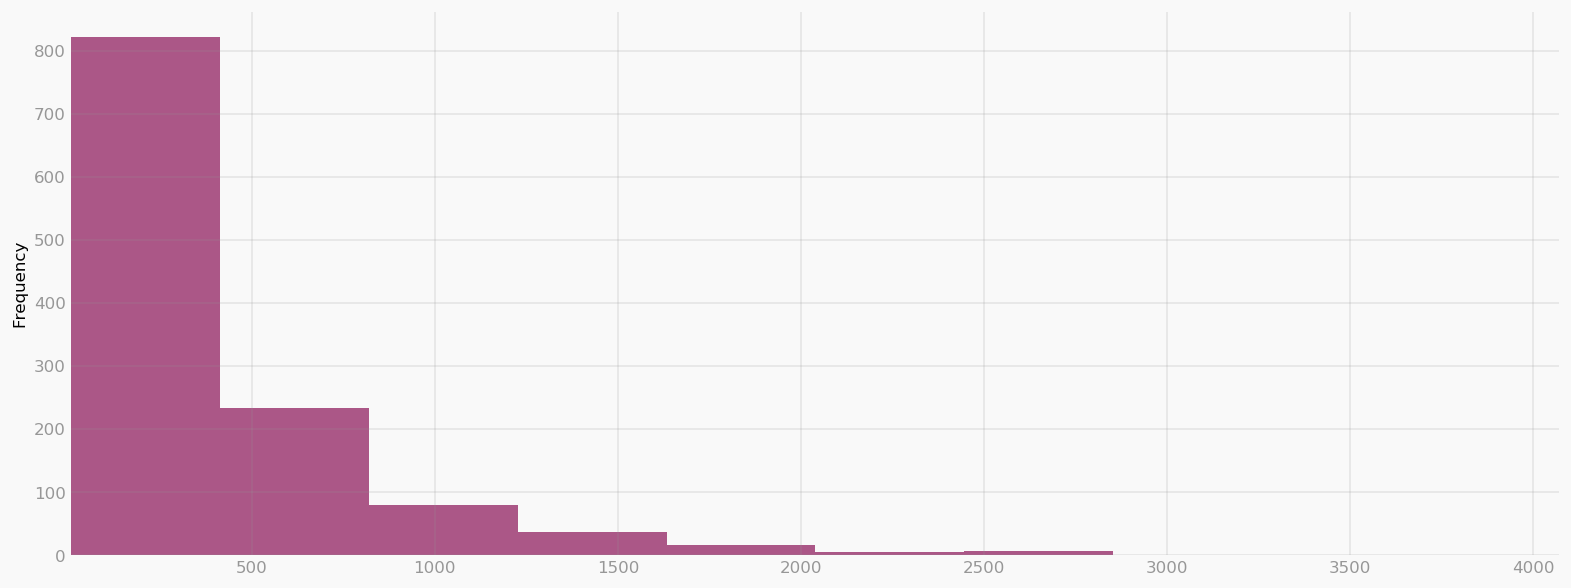

In [8]:
df['price'].plot(kind='hist');


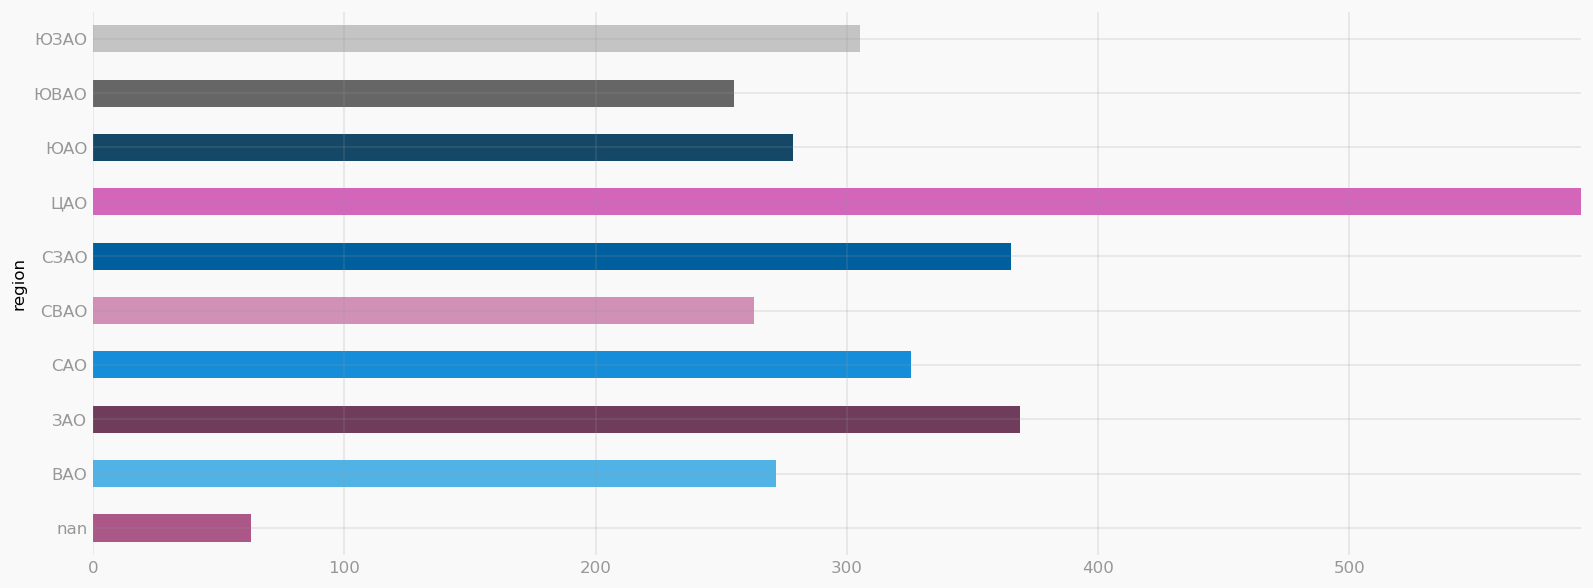

In [9]:
df.groupby('region')['price'].mean().plot(kind='barh');


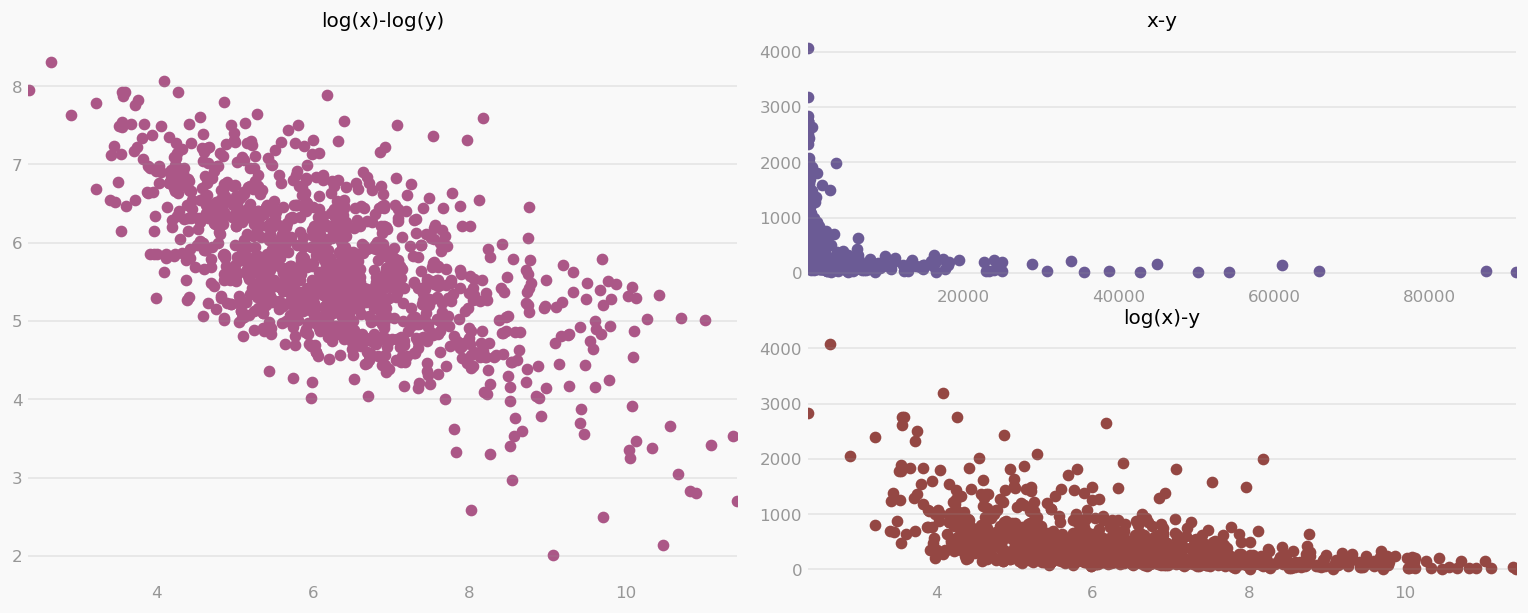

In [10]:
plt.subplot(222)
plt.scatter(df.area, df.price, c="#6B5B95")
plt.title('x-y')

plt.subplot(224)
plt.scatter(np.log(df.area), df.price, c="#944743")

plt.title('log(x)-y')

plt.subplot(121)
plt.scatter(np.log(df.area), np.log(df.price))
plt.title('log(x)-log(y)');


Now, for convenience, we’ll create two classes to separetly process the numerical and categorical features of our data. 

In [11]:
class NumTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, columns, method=None):
        self.columns = columns
        self.method = method
        self.transformer_dict = {'power': PowerTransformer,
                                 'scaler': StandardScaler}

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X[self.columns].copy()
        if not self.method:
            return X.values
        else:
            return self.transformer_dict[self.method]().fit_transform(X)


class CatTransformer(BaseEstimator, TransformerMixin):

        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            X = X[self.columns].copy()
            for column in X.columns:
                X[column] = LabelEncoder().fit_transform(X[column])
            return X


To assemble different transformers and regressors and to avoid knowledge leakage, we will use sklearn’s pipeline object. 

In [12]:
def create_model(reg,
                 num_features,
                 cat_features,
                 features_transformer_method=None,
                 include_bias=False,
                 degree=1,
                 interaction_only=False,
                 memory=None):

    num_transformer = Pipeline(
        [('tnum', NumTransformer(num_features,
                                 method=features_transformer_method)),
         ('pol', PolynomialFeatures(include_bias=include_bias,
                                    degree=degree,
                                    interaction_only=interaction_only))])

    cat_transformer = Pipeline([('cat', CatTransformer(cat_features)),
                                ('ohe', OneHotEncoder(sparse=False))])

    features_tr = FeatureUnion([('tranf1', num_transformer),
                                ('transf2', cat_transformer)])

    return Pipeline([('transf', features_tr),
                     ('reg', reg)], memory=memory)


In [13]:
# Globals
features = ['area', 'region', 'lease_amount']
num_features = ['area', 'lease_amount']
cat_features = ['region']
target = ['price']
X = df[features]
y = df[target]
random_state = 1
train_size = 0.75
test_size = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=train_size,
                                                    test_size=test_size,
                                                    random_state=random_state)


## Linear regression models

We’ll start with the most basic model, which is a simple linear regression. We can augment the basic set of features with several polynomial terms. Also, when using linear regression on economic indicators, we often need to perform a log transformation. Power transformer from scikit-learn performs the log transformation but with some minor improvements.

In [14]:
linear_regression_simple = create_model(LinearRegression(),
                                        num_features=num_features,
                                        cat_features=cat_features,
                                        features_transformer_method=None,
                                        include_bias=False,
                                        degree=1,
                                        interaction_only=False)

linear_regression_power = create_model(LinearRegression(),
                                       num_features=num_features,
                                       cat_features=cat_features,
                                       features_transformer_method='power',
                                       include_bias=False,
                                       degree=1,
                                       interaction_only=False)

linear_regression_power_qudr = create_model(LinearRegression(),
                                            num_features=num_features,
                                            cat_features=cat_features,
                                            features_transformer_method='power',
                                            include_bias=False,
                                            degree=2,
                                            interaction_only=False)

linear_regression_power_qub = create_model(LinearRegression(),
                                           num_features=num_features,
                                           cat_features=cat_features,
                                           features_transformer_method='power',
                                           include_bias=False,
                                           degree=3,
                                           interaction_only=False)

linear_regression_results = {'name': [],
                             'r_sq_train': [],
                             'r_sq_test': []}

models_LR_simplr = [linear_regression_simple,
                    linear_regression_power,
                    linear_regression_power_qudr,
                    linear_regression_power_qub]

models_LR_simple_names = ['simple', 'power', 'power_qudr', 'power_qub']
liner_models_simple_names = []

for model, name in zip(models_LR_simplr, models_LR_simple_names):

    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    linear_regression_results['name'].append('Linear Regression' + ", " + name)
    linear_regression_results['r_sq_train'].append(r2_score(y_train, pred_train))
    linear_regression_results['r_sq_test'].append(r2_score(y_test, pred_test))

pd.DataFrame(linear_regression_results).set_index('name')


,r_sq_train,r_sq_test
name,,
"Linear Regression, simple",0.15,0.13
"Linear Regression, power",0.36,0.32
"Linear Regression, power_qudr",0.54,0.41
"Linear Regression, power_qub",0.64,-1.69


Now, let’s try the regularized regression models. Linear models are very cheap to train, so we’ll use GridSearchCV to find the best set of hyper-parameters.

In [15]:
param_grid = {'reg__alpha': np.logspace(-3, 3, 50),
              'transf__tranf1__pol__degree': [1, 2, 3]}

lasso = create_model(Lasso(),
                     num_features=num_features,
                     cat_features=cat_features,
                     features_transformer_method='power',
                     include_bias=False,
                     degree=2,
                     interaction_only=False)

search_lasso = GridSearchCV(lasso, cv=5,
                            param_grid=param_grid)

search_lasso.fit(X_train, y_train)

best_lasso = search_lasso.best_estimator_

pred_train = best_lasso.predict(X_train)
pred_test = best_lasso.predict(X_test)

regularized_regression_results = {'name': ['Lasso'],
                                  'r_sq_train': [r2_score(y_train,
                                                          pred_train)],
                                  'r_sq_test': [r2_score(y_test,
                                                         pred_test)]}

pd.DataFrame(regularized_regression_results).set_index('name')


,r_sq_train,r_sq_test
name,,
Lasso,0.57,0.49


In [33]:
search_lasso.best_params_


{'reg__alpha': 8.286427728546842, 'transf__tranf1__pol__degree': 3}

In [16]:
param_grid = {'reg__alpha': np.logspace(-3, 3, 50),
              'transf__tranf1__pol__degree': [1, 2, 3]}

ridge = create_model(Ridge(),
                     num_features=num_features,
                     cat_features=cat_features,
                     features_transformer_method='power',
                     include_bias=False,
                     degree=2,
                     interaction_only=False)

search_ridge = GridSearchCV(ridge, cv=5,
                            param_grid=param_grid)

search_ridge.fit(X_train, y_train)

best_ridge = search_ridge.best_estimator_.fit(X_train, y_train)

pred_train = best_ridge.predict(X_train)
pred_test = best_ridge.predict(X_test)

regularized_regression_results = {'name': ['Ridge'],
                                  'r_sq_train': [r2_score(y_train,
                                                          pred_train)],
                                  'r_sq_test': [r2_score(y_test,
                                                         pred_test)]}

pd.DataFrame(regularized_regression_results)


,name,r_sq_train,r_sq_test
0,Ridge,0.60,0.47


In [17]:
search_ridge.best_params_


{'reg__alpha': 10.985411419875572, 'transf__tranf1__pol__degree': 3}

## SVR

Next, we will use Support Vector Regression with the RBF kernel. SVR needs a lot of tuning, and the results are very sensitive to the hyper-parameters used. Unfortunately, it’s usually not feasible to try every possible set of hyper-parameters, as SVR is a rather slow algorithm, so we’ll use Bayesian search instead.

In [18]:
search_spaces = {'reg__gamma': Real(1e-3, 1e+3),
                 'reg__C': Real(1e-3, 1e+3),
                 'transf__tranf1__tnum__method': Categorical([None,
                                                              'scaler',
                                                              'power']),
                 'transf__tranf1__pol__degree': Integer(1, 4)}

cachedir = mkdtemp() # caching to speed up the algoritm
svr = create_model(SVR(),
                   num_features=num_features,
                   cat_features=cat_features,
                   features_transformer_method='power',
                   include_bias=False,
                   degree=2,
                   interaction_only=False,
                   memory=cachedir)

search_svr = BayesSearchCV(svr, cv=5,
                           search_spaces=search_spaces,
                           random_state=random_state)

search_svr.fit(X_train, y_train)

best_svr = search_svr.best_estimator_

pred_train = best_svr.predict(X_train)
pred_test = best_svr.predict(X_test)

svr_results = {'name': ['SVR'],
               'r_sq_train': [r2_score(y_train, pred_train)],
               'r_sq_test': [r2_score(y_test, pred_test)]}

rmtree(cachedir)
pd.DataFrame(svr_results).set_index('name')


,r_sq_train,r_sq_test
name,,
SVR,0.44,0.46


In [18]:
search_svr.best_params_


{'reg__C': 1000.0,
 'reg__gamma': 0.001,
 'transf__tranf1__pol__degree': 3,
 'transf__tranf1__tnum__method': 'power'}

## Gradient Boosting

Our final model is gradient boosting. We will use CatBoost algorithm, created by Yandex, as it is very easy to use and you really don't need an extensive tuning to get good results out of it.

In [19]:
cat_boost = CatBoostRegressor(iterations=1000).fit(X_train, y_train,
                                                   cat_features=cat_features,
                                                   verbose=0)

pred_train = cat_boost.predict(X_train)
pred_test = cat_boost.predict(X_test)

cat_boost_results = {'name': ['CatBoost'],
                     'r_sq_train': [r2_score(y_train,
                                             pred_train)],
                     'r_sq_test': [r2_score(y_test,
                                            pred_test)]}

pd.DataFrame(cat_boost_results).set_index('name')


,r_sq_train,r_sq_test
name,,
CatBoost,0.69,0.66


With gradient boosting we can extract importance scores for each feature.

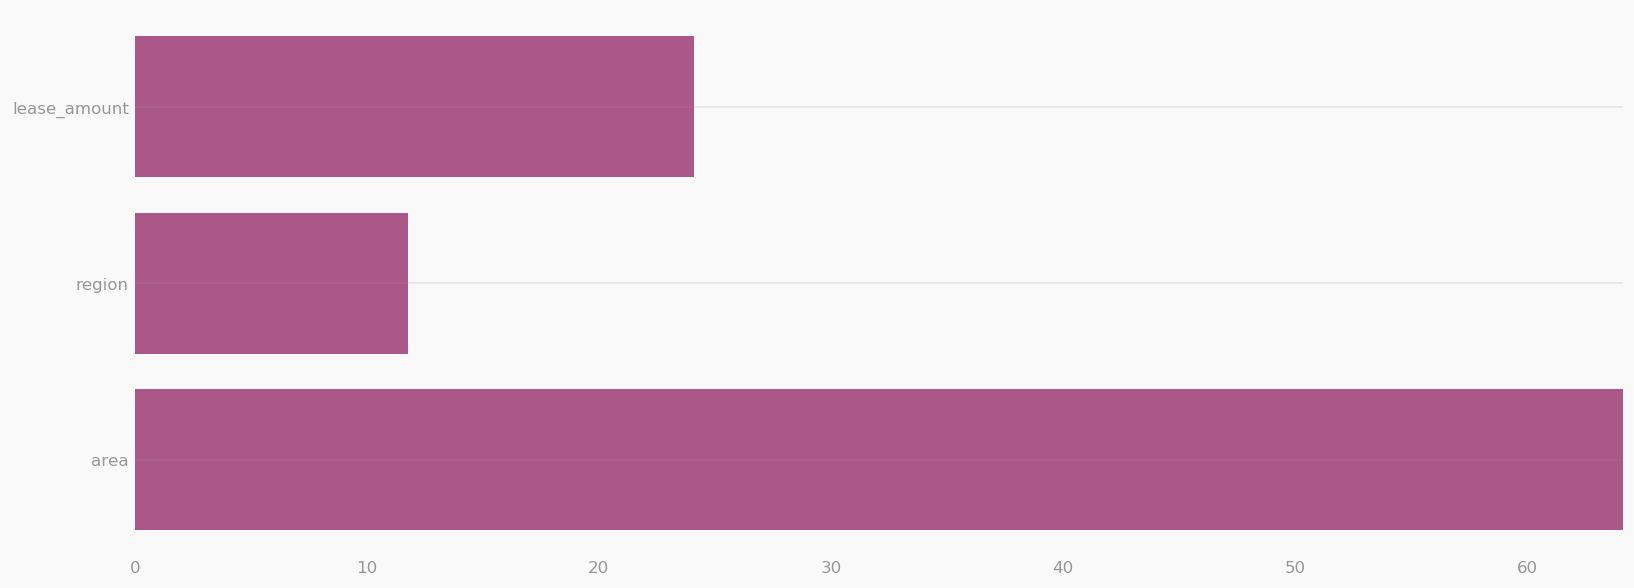

In [20]:
plt.barh(cat_boost.feature_names_, cat_boost.feature_importances_);


## Results

Finally, we will cross-validate all the models on the whole dataset.

In [21]:
scoring = ['r2',
           'neg_mean_absolute_error',
           'neg_mean_squared_error']

cat_boost_params = {'cat_features': cat_features,
                    'verbose': 0}

models = [linear_regression_power_qudr,
          best_ridge,
          best_lasso,
          best_svr,
          cat_boost]

names = ['Linear Regression',
         'Ridge',
         'Lasso',
         'SVR',
         'CatBoost']

params = [cat_boost_params if name == 'CatBoost' else None for name in names]


def cross_validate_results(X,
                           y,
                           models,
                           names,
                           params,
                           scoring='r2',
                           n_splits=10,
                           random_state=0,
                           shuffle=True):

    results = {it + '_' + key: [] for key in scoring for it in ['train',
                                                                'test']}
    results['name'] = []

    for model, name, params in zip(models, names, params):

        res = cross_validate(model,
                             X,
                             y,
                             scoring=scoring,
                             cv=KFold(n_splits=n_splits,
                                      shuffle=shuffle,
                                      random_state=random_state),
                             fit_params=params)

        results['name'].append(name)

        for key in results.keys():
            if key in res.keys():
                results[key].append(np.mean(res[key]))

    return pd.DataFrame(results).set_index('name')

cross_validate_results(X=X,
                       y=y,
                       models=models,
                       names=names,
                       params=params,
                       scoring=scoring,
                       random_state=random_state)


,train_r2,test_r2,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_squared_error,test_neg_mean_squared_error
name,,,,,,
Linear Regression,0.56,0.27,-176.22,-248.87,-81478.11,-121187.27
Ridge,0.60,0.40,-159.87,-199.04,-72349.43,-98999.99
Lasso,0.57,0.44,-169.84,-192.54,-78661.52,-96708.69
SVR,0.45,0.41,-175.30,-183.92,-101622.73,-109865.04
CatBoost,0.71,0.62,-135.14,-149.59,-53552.87,-69635.84


It is apparent from the table above that gradient boosting considerably outperforms all other models.